In [7]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

from numpy import linalg
from matplotlib import cm
from scipy.linalg import logm
from numpy.linalg import svd, eig

import torch
import torch.nn as nn
import torch.autograd as ag
import numpy as np
from scipy.integrate import solve_ivp

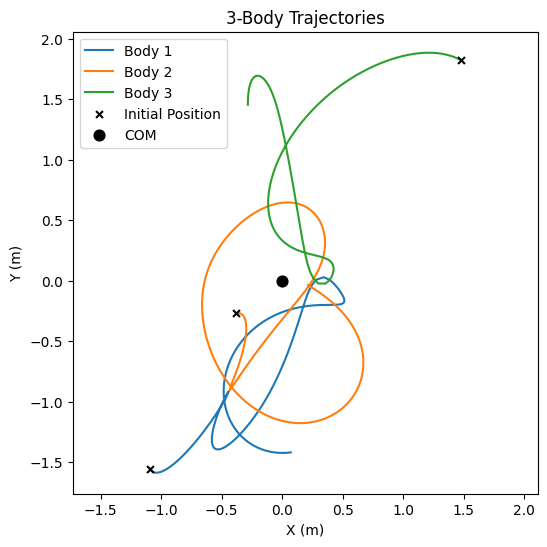

In [3]:
# Physical constants
n      = 3  # n-bodies
G      = 3 # gravitational constant
masses = np.ones(n) # bodies have equal masses == 1kg

# how big the initial condition “box” is, and how fast the bodies start
L       = 3 # positions uniform in [-L,L]^2
v_scale = 0.5 # velocities uniform in [-v_scale,v_scale]

# time grid
dt   = 0.01
Nt   = 500
tend = dt*(Nt-1)
t    = np.linspace(0, tend, Nt)

# Initial conditions set at RANDOM
# random positions in a box
initial_positions = np.random.uniform(-L, L, size=(n,2))
initial_velocities = np.random.uniform(-v_scale, v_scale, size=(n,2))

# shift to center-of-mass frame (zero net momentum + COM at origin)
Mtot = masses.sum()
COM_r = (masses[:,None]*initial_positions).sum(axis=0)/Mtot
COM_v = (masses[:,None]*initial_velocities).sum(axis=0)/Mtot
initial_positions  -= COM_r
initial_velocities -= COM_v

# pack into state vector
x0 = np.hstack((initial_positions.flatten(),
                initial_velocities.flatten()))

# Gravitational dynamics for n-bodies
def n_body_rhs(t, state):
    pos = state[:2*n].reshape(n,2)
    vel = state[2*n:4*n].reshape(n,2)
    acc = np.zeros_like(pos)
    for i in range(n):
        for j in range(n):
            if i == j: continue
            rij = pos[i] - pos[j]
            acc[i] += -G * masses[j] * rij / np.linalg.norm(rij)**3
    return np.hstack((vel.flatten(), acc.flatten()))

# Solve simulation with initial conditions
sol  = solve_ivp(n_body_rhs, (0, tend), x0, t_eval=t,
                 rtol=1e-9, atol=1e-9)
data = sol.y  # shape (4n, Nt)

# Plotting
plt.figure(figsize=(6,6))
for i in range(n):
    xi = data[2*i,     :]
    yi = data[2*i + 1, :]
    plt.plot(xi, yi, '-', label=f'Body {i+1}')
initial_xs = [data[2*i, 0]     for i in range(n)]
initial_ys = [data[2*i + 1, 0] for i in range(n)]
plt.scatter(initial_xs, initial_ys, c='k', marker='x',s=25, label='Initial Position', zorder=5)
plt.scatter(0, 0, marker='o', s= 60, c='k', label='COM')
plt.axis('equal')
plt.xlabel('X (m)'); plt.ylabel('Y (m)')
plt.title(f'{n}-Body Trajectories')
plt.legend()
plt.show()

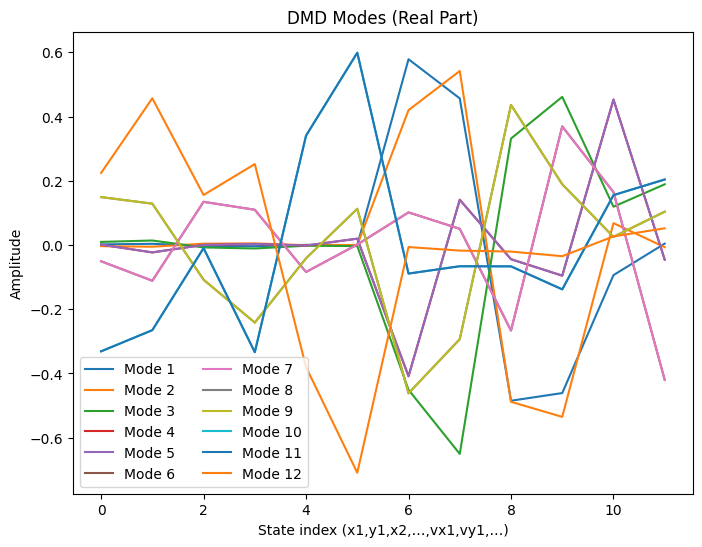

Discrete-time eigenvalues:
 [0.08028045+0.j         0.22688487+0.j         0.5563325 +0.j
 0.89440076+0.23656249j 0.89440076-0.23656249j 1.00189612+0.02913841j
 1.00189612-0.02913841j 0.9923507 +0.01646249j 0.9923507 -0.01646249j
 1.00390329+0.00291693j 1.00390329-0.00291693j 0.99925146+0.j        ]

Continuous-time eigenvalues:
 [-2.52222912e+02 +0.j         -1.48331257e+02 +0.j
 -5.86389146e+01 +0.j         -7.77923806e+00+25.85716829j
 -7.77923806e+00-25.85716829j  2.31706226e-01 +2.90750644j
  2.31706226e-01 -2.90750644j -7.54112421e-01 +1.65878612j
 -7.54112421e-01 -1.65878612j  3.89991337e-01 +0.29055849j
  3.89991337e-01 -0.29055849j -7.48820550e-02 +0.j        ]


In [4]:
# Building DMD
X  = data # full state: shape (4n, Nt)
X1 = X[:, :-1] # columns 0…Nt-2
X2 = X[:,  1:] # columns 1…Nt-1

U, S, Vh    = svd(X1, full_matrices=False)
A_tilde     = U.conj().T @ X2 @ Vh.T @ np.diag(1/S)
eigvals, W  = eig(A_tilde)
Phi         = U @ W
lambda_c    = np.log(eigvals) / dt

# Plotting DMD
plt.figure(figsize=(8,6))
for i in range(Phi.shape[1]):
    plt.plot(np.real(Phi[:, i]), label=f'Mode {i+1}')
plt.xlabel('State index (x1,y1,x2,…,vx1,vy1,…)')
plt.ylabel('Amplitude')
plt.title('DMD Modes (Real Part)')
plt.legend(ncol=2)
plt.show()

print("Discrete-time eigenvalues:\n", eigvals)
print("\nContinuous-time eigenvalues:\n", lambda_c)

Epoch    0 | Data 1.13e+00 | Phys 3.21e+03
Epoch  200 | Data 1.58e+00 | Phys 6.64e+00
Epoch  400 | Data 1.66e+00 | Phys 3.66e+00
Epoch  600 | Data 1.74e+00 | Phys 2.33e+00
Epoch  800 | Data 1.81e+00 | Phys 1.62e+00
Epoch 1000 | Data 1.88e+00 | Phys 1.20e+00
Epoch 1200 | Data 1.94e+00 | Phys 9.30e-01
Epoch 1400 | Data 1.99e+00 | Phys 7.55e-01
Epoch 1600 | Data 2.03e+00 | Phys 6.36e-01
Epoch 1800 | Data 2.06e+00 | Phys 5.53e-01


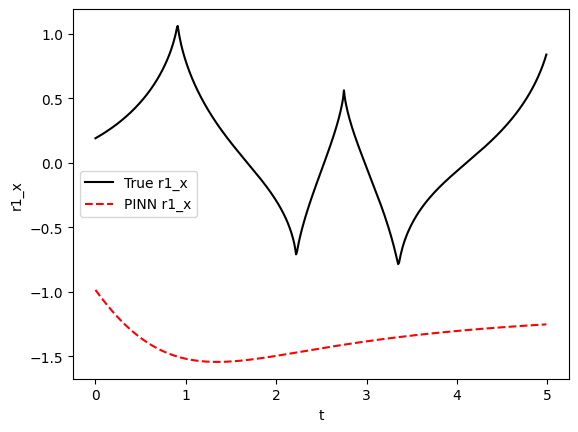

In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as ag
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# ─── 1) GENERATE SIMULATION DATA ─────────────────────────────────────────────
n      = 3
G      = 3.0
masses = np.ones(n)

# Random ICs centered on COM
L, v_scale = 3.0, 0.5
pos0 = np.random.uniform(-L,L,(n,2))
vel0 = np.random.uniform(-v_scale,v_scale,(n,2))
Mtot = masses.sum()
COM_r = (masses[:,None]*pos0).sum(0)/Mtot
COM_v = (masses[:,None]*vel0).sum(0)/Mtot
pos0 -= COM_r;  vel0 -= COM_v

x0 = np.hstack((pos0.flatten(), vel0.flatten()))
def n_body_rhs(t, state):
    pos = state[:2*n].reshape(n,2)
    vel = state[2*n:4*n].reshape(n,2)
    acc = np.zeros_like(pos)
    for i in range(n):
        for j in range(n):
            if i==j: continue
            rij = pos[i]-pos[j]
            acc[i] += -G*masses[j]*rij/np.linalg.norm(rij)**3
    return np.hstack((vel.flatten(), acc.flatten()))

dt, Nt = 0.01, 500
t_sim = np.linspace(0, dt*(Nt-1), Nt)
sol   = solve_ivp(n_body_rhs, (0, t_sim[-1]), x0, t_eval=t_sim,
                  rtol=1e-9, atol=1e-9)
data_sim = sol.y.T  # (Nt,4n)

# Convert to tensors
t_data = torch.tensor(t_sim, dtype=torch.float32).unsqueeze(1)   # (Nt,1)
x_data = torch.tensor(data_sim, dtype=torch.float32)            # (Nt,4n)

# ─── 2) PINN DEFINITION ──────────────────────────────────────────────────────
class NBodyPINN(nn.Module):
    def __init__(self, n, hidden=[64,64]):
        super().__init__()
        dims = [1] + hidden + [4*n]
        layers = []
        for i in range(len(dims)-2):
            layers += [nn.Linear(dims[i],dims[i+1]), nn.Tanh()]
        layers += [nn.Linear(dims[-2], dims[-1])]
        self.net = nn.Sequential(*layers)
    def forward(self, t):
        return self.net(t)

model     = NBodyPINN(n)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
mse       = nn.MSELoss()

# ─── 3) COLLocation POINTS ───────────────────────────────────────────────────
Ncol = 200
t_col = torch.tensor(
    np.random.uniform(0, t_sim[-1], (Ncol,1)),
    requires_grad=True,
    dtype=torch.float32
)

# ─── 4) LOSS FUNCTIONS ──────────────────────────────────────────────────────
def data_loss():
    return mse(model(t_data), x_data)

def physics_loss():
    # Predict at collocation times
    x_pred = model(t_col)              # (Ncol,4n)
    # First derivative per output dim
    x_t_list = []
    for j in range(4*n):
        grad_j = ag.grad(x_pred[:,j], t_col,
                         grad_outputs=torch.ones_like(x_pred[:,j]),
                         create_graph=True)[0]
        x_t_list.append(grad_j)
    x_t = torch.cat(x_t_list, dim=1)   # (Ncol,4n)
    # Second derivative per output dim
    x_tt_list = []
    for j in range(4*n):
        grad2_j = ag.grad(x_t[:,j], t_col,
                          grad_outputs=torch.ones_like(x_t[:,j]),
                          create_graph=True)[0]
        x_tt_list.append(grad2_j)
    x_tt = torch.cat(x_tt_list, dim=1) # (Ncol,4n)

    # Extract predicted positions & accelerations
    pos_pred = x_pred[:, :2*n].view(-1,n,2)
    acc_pred = x_tt[:,  :2*n].view(-1,n,2)

    # Build ODE residual
    loss_p = 0.0
    for i in range(n):
        force_sum = torch.zeros_like(acc_pred[:,i])
        for j in range(n):
            if i==j: continue
            rij = pos_pred[:,i] - pos_pred[:,j]
            force_sum += -G*masses[j] * rij / (rij.norm(dim=1,keepdim=True)**3)
        loss_p += mse(acc_pred[:,i], force_sum)
    return loss_p

# ─── 5) TRAINING LOOP ────────────────────────────────────────────────────────
epochs = 2000
for ep in range(epochs):
    optimizer.zero_grad()
    Ld = data_loss()
    Lp = physics_loss()
    (Ld + Lp).backward()
    optimizer.step()
    if ep%200==0:
        print(f"Epoch {ep:4d} | Data {Ld.item():.2e} | Phys {Lp.item():.2e}")

# ─── 6) EVALUATION ──────────────────────────────────────────────────────────
with torch.no_grad():
    x_pinn = model(t_data).numpy()

plt.figure()
plt.plot(t_sim, data_sim[:,0], 'k-', label='True r1_x')
plt.plot(t_sim, x_pinn[:,0], 'r--', label='PINN r1_x')
plt.legend(); plt.xlabel('t'); plt.ylabel('r1_x'); plt.show()


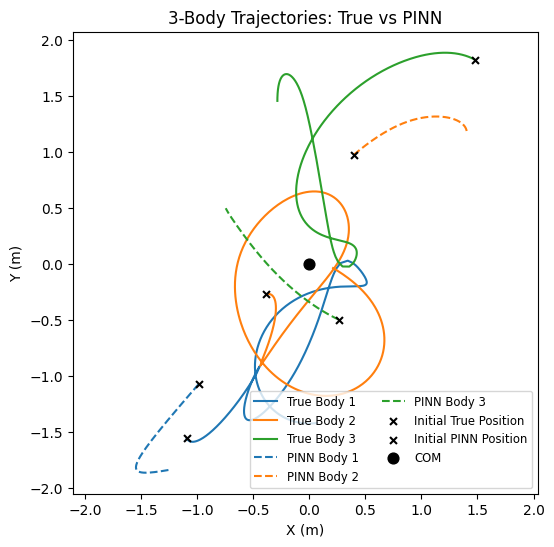

In [12]:
# Plot the simulated trajectories & PINN trajectories

# transpose data → (Nt,4n) to match x_pinn
data_T = data.T   # now (Nt,4n)

plt.figure(figsize=(6,6))

# 1) plot true simulation orbits
for i in range(n):
    xi = data[2*i,     :]   # true x_i(t)
    yi = data[2*i + 1, :]   # true y_i(t)
    plt.plot(xi, yi, 'C'+str(i), lw=1.5, label=f'True Body {i+1}')

# 2) plot PINN‐predicted orbits (dashed)
for i in range(n):
    xi_p = x_pinn[:, 2*i]       # pred x_i(t)
    yi_p = x_pinn[:, 2*i + 1]   # pred y_i(t)
    plt.plot(xi_p, yi_p, '--', color=f'C{i}', lw=1.5, label=f'PINN Body {i+1}')

# 3) initial true positions
initial_xs = [data[2*i, 0]     for i in range(n)]
initial_ys = [data[2*i + 1, 0] for i in range(n)]
plt.scatter(initial_xs, initial_ys,
            c='k', marker='x', s=25, label='Initial True Position', zorder=5)

# 4) initial PINN positions (should coincide, but just for clarity)
initial_xs_p = x_pinn[0, 0:2*n:2]
initial_ys_p = x_pinn[0, 1:2*n:2]
plt.scatter(initial_xs_p, initial_ys_p,
            c='k', marker='x', s=25, label='Initial PINN Position', zorder=5)

# 5) center‐of‐mass marker
plt.scatter(0, 0, marker='o', s= 60, c='k', label='COM')
plt.axis('equal')
plt.xlabel('X (m)'); plt.ylabel('Y (m)')
plt.title(f'{n}-Body Trajectories: True vs PINN')
plt.legend(loc='best', fontsize='small', ncol=2)
plt.show()


Epoch    0 | Data 1.98e+00 | Phys 3.83e+04 | IC 9.07e-01
Epoch  200 | Data 1.94e+00 | Phys 2.92e+01 | IC 7.71e-01
Epoch  400 | Data 1.96e+00 | Phys 2.13e+01 | IC 7.59e-01
Epoch  600 | Data 1.97e+00 | Phys 1.67e+01 | IC 7.50e-01
Epoch  800 | Data 1.99e+00 | Phys 1.36e+01 | IC 7.43e-01
Epoch 1000 | Data 2.01e+00 | Phys 1.14e+01 | IC 7.37e-01
Epoch 1200 | Data 2.03e+00 | Phys 9.78e+00 | IC 7.31e-01
Epoch 1400 | Data 2.05e+00 | Phys 8.45e+00 | IC 7.25e-01
Epoch 1600 | Data 2.07e+00 | Phys 7.36e+00 | IC 7.19e-01
Epoch 1800 | Data 2.10e+00 | Phys 6.44e+00 | IC 7.12e-01


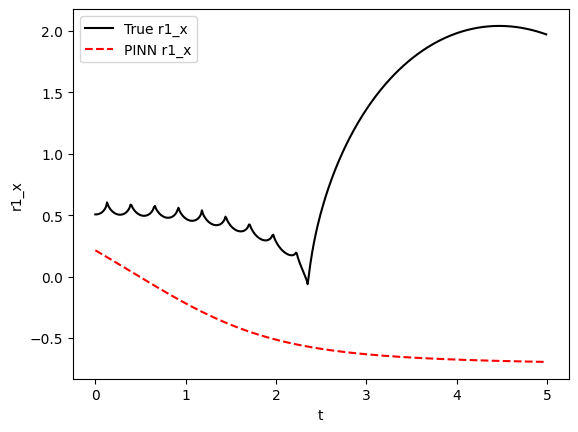

In [20]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as ag
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# ─── 1) GENERATE SIMULATION DATA ─────────────────────────────────────────────
n      = 3
G      = 3.0
masses = np.ones(n)

# Random ICs centered on COM
L, v_scale = 3.0, 0.5
pos0 = np.random.uniform(-L,L,(n,2))
vel0 = np.random.uniform(-v_scale,v_scale,(n,2))
Mtot = masses.sum()
COM_r = (masses[:,None]*pos0).sum(0)/Mtot
COM_v = (masses[:,None]*vel0).sum(0)/Mtot
pos0 -= COM_r;  vel0 -= COM_v

x0 = np.hstack((pos0.flatten(), vel0.flatten()))
def n_body_rhs(t, state):
    pos = state[:2*n].reshape(n,2)
    vel = state[2*n:4*n].reshape(n,2)
    acc = np.zeros_like(pos)
    for i in range(n):
        for j in range(n):
            if i==j: continue
            rij = pos[i]-pos[j]
            acc[i] += -G*masses[j]*rij/np.linalg.norm(rij)**3
    return np.hstack((vel.flatten(), acc.flatten()))

dt, Nt = 0.01, 500
t_sim = np.linspace(0, dt*(Nt-1), Nt)
sol   = solve_ivp(n_body_rhs, (0, t_sim[-1]), x0, t_eval=t_sim,
                  rtol=1e-9, atol=1e-9)
data_sim = sol.y.T  # (Nt,4n)

# Convert to tensors
t_data = torch.tensor(t_sim, dtype=torch.float32).unsqueeze(1)   # (Nt,1)
x_data = torch.tensor(data_sim, dtype=torch.float32)            # (Nt,4n)

# ─── 2) PINN DEFINITION ──────────────────────────────────────────────────────
class NBodyPINN(nn.Module):
    def __init__(self, n, hidden=[64,64]):
        super().__init__()
        dims = [1] + hidden + [4*n]
        layers = []
        for i in range(len(dims)-2):
            layers += [nn.Linear(dims[i],dims[i+1]), nn.Tanh()]
        layers += [nn.Linear(dims[-2], dims[-1])]
        self.net = nn.Sequential(*layers)
    def forward(self, t):
        return self.net(t)

model     = NBodyPINN(n)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
mse       = nn.MSELoss()

# ─── 3) COLLocation POINTS ───────────────────────────────────────────────────
Ncol = 200
t_col = torch.tensor(
    np.random.uniform(0, t_sim[-1], (Ncol,1)),
    requires_grad=True,
    dtype=torch.float32
)

# ─── 4) LOSS FUNCTIONS ──────────────────────────────────────────────────────
def data_loss():
    return mse(model(t_data), x_data)

def ic_loss():
    t0 = torch.zeros(1,1)
    x0_pred = model(t0)
    x0_true = x_data[0:1]
    return mse(x0_pred, x0_true)

def physics_loss():
    # Predict at collocation times
    x_pred = model(t_col)              # (Ncol,4n)
    # First derivative per output dim
    x_t_list = []
    for j in range(4*n):
        grad_j = ag.grad(x_pred[:,j], t_col,
                         grad_outputs=torch.ones_like(x_pred[:,j]),
                         create_graph=True)[0]
        x_t_list.append(grad_j)
    x_t = torch.cat(x_t_list, dim=1)   # (Ncol,4n)
    # Second derivative per output dim
    x_tt_list = []
    for j in range(4*n):
        grad2_j = ag.grad(x_t[:,j], t_col,
                          grad_outputs=torch.ones_like(x_t[:,j]),
                          create_graph=True)[0]
        x_tt_list.append(grad2_j)
    x_tt = torch.cat(x_tt_list, dim=1) # (Ncol,4n)

    # Extract predicted positions & accelerations
    pos_pred = x_pred[:, :2*n].view(-1,n,2)
    acc_pred = x_tt[:,  :2*n].view(-1,n,2)

    # Build ODE residual
    loss_p = 0.0
    for i in range(n):
        force_sum = torch.zeros_like(acc_pred[:,i])
        for j in range(n):
            if i==j: continue
            rij = pos_pred[:,i] - pos_pred[:,j]
            force_sum += -G*masses[j] * rij / (rij.norm(dim=1,keepdim=True)**3)
        loss_p += mse(acc_pred[:,i], force_sum)
    return loss_p

# ─── 5) TRAINING LOOP ────────────────────────────────────────────────────────
for epoch in range(epochs):
    optimizer.zero_grad()

    Ld = data_loss()      # fit to your 500 simulated snapshots
    Lp = physics_loss()   # enforce Newton’s law at collocation points
    Li = ic_loss()        # force network to exactly match x(0)

    # total loss function
    loss = Ld + Lp + 10.0*Li

    loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch:4d} | Data {Ld:.2e} | Phys {Lp:.2e} | IC {Li:.2e}")


# ─── 6) EVALUATION ──────────────────────────────────────────────────────────
with torch.no_grad():
    x_pinn = model(t_data).numpy()

plt.figure()
plt.plot(t_sim, data_sim[:,0], 'k-', label='True r1_x')
plt.plot(t_sim, x_pinn[:,0], 'r--', label='PINN r1_x')
plt.legend(); plt.xlabel('t'); plt.ylabel('r1_x'); plt.show()


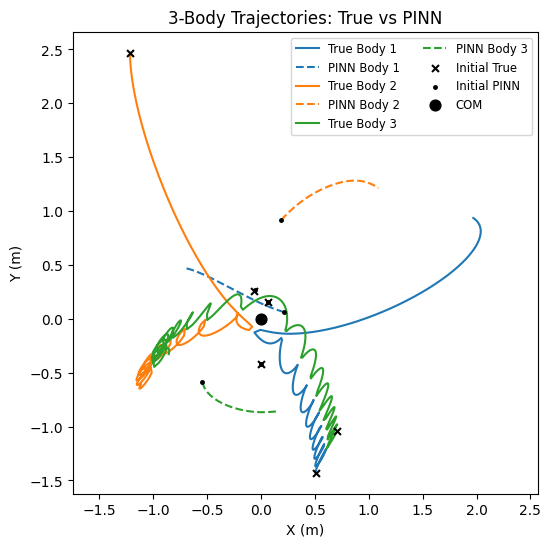

In [21]:
# ─── PLOTTING ─────────────────────────────────────────────────────────────────
# data_sim is (Nt,4n); transpose to (4n,Nt) to index as data[2*i,:]
data = data_sim.T  

plt.figure(figsize=(6,6))
for i in range(n):
    # true
    xi = data[2*i,    :]
    yi = data[2*i+1,  :]
    plt.plot(xi, yi, 'C'+str(i), lw=1.5, label=f'True Body {i+1}')
    # PINN
    xi_p = x_pinn[:,2*i]
    yi_p = x_pinn[:,2*i+1]
    plt.plot(xi_p, yi_p, '--', c=f'C{i}', lw=1.5, label=f'PINN Body {i+1}')

# initial positions
initial_xs = data[0::2, 0]
initial_ys = data[1::2, 0]
plt.scatter(initial_xs, initial_ys, c='k', marker='x', s=25, label='Initial True', zorder=5)
plt.scatter(x_pinn[0,0::2], x_pinn[0,1::2], c='k', marker='.', s=25, label='Initial PINN', zorder=5)

plt.scatter(0,0, marker='o', c='k', s=60, label='COM')
plt.axis('equal')
plt.xlabel('X (m)'); plt.ylabel('Y (m)')
plt.title(f'{n}-Body Trajectories: True vs PINN')
plt.legend(loc='best', fontsize='small', ncol=2)
plt.show()